In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('football_ml_ready.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [5]:
# Define Features and Target
# We exclude scores and names to prevent leakage
features = [
    'is_neutral', 'is_true_home',
    'home_jerarquia_score', 'home_total_matches', 'home_goals_per_match', 'home_diversity_index', 'home_star_reliability',
    'away_jerarquia_score', 'away_total_matches', 'away_goals_per_match', 'away_diversity_index', 'away_star_reliability'
]
target = 'target'

In [7]:
# Convert boolean 'neutral' to numeric 'is_neutral'
df['is_neutral'] = df['neutral'].astype(int)

# Double check the other match-specific features
if 'is_true_home' not in df.columns:
    df['is_true_home'] = ((df['neutral'] == False) & (df['home_team'] == df['country'])).astype(int)

# Now define your features list safely
features = [
    'is_neutral', 'is_true_home',
    'home_jerarquia_score', 'home_total_matches', 'home_goals_per_match', 'home_diversity_index', 'home_star_reliability',
    'away_jerarquia_score', 'away_total_matches', 'away_goals_per_match', 'away_diversity_index', 'away_star_reliability'
]

# Check if all features exist in the dataframe to avoid another KeyError
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"Error: Missing columns in df: {missing_features}")
else:
    print("All features found in index. Ready to train!")

All features found in index. Ready to train!


In [8]:
# Temporal Split
train_df = df[df['year'] < 2024].dropna()
val_df = df[df['year'] == 2024].dropna()
test_df = df[df['year'] == 2025].dropna()

X_train, y_train, weights_train = train_df[features], train_df[target], train_df['train_weight']
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

In [9]:
# Remap targets for XGBoost (needs 0, 1, 2 instead of -1, 0, 1)
y_train_map = y_train + 1
y_val_map = y_val + 1
y_test_map = y_test + 1

In [11]:
# --- MODEL 1: Logistic Regression (Baseline) ---
print("Training Logistic Regression...")
# Removed multi_class='multinomial'
lr = LogisticRegression(max_iter=1000) 
lr.fit(X_train, y_train, sample_weight=weights_train)
lr_preds = lr.predict(X_val)
print(f"LR Validation Accuracy: {accuracy_score(y_val, lr_preds):.4f}")

Training Logistic Regression...
LR Validation Accuracy: 0.5763


c:\Users\Aura\Documents\proyectos\football_ml\football_env\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# --- MODEL 2: XGBoost (Advanced) ---
print("\nTraining XGBoost...")
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_map, sample_weight=weights_train)
xgb_preds = xgb.predict(X_val)
print(f"XGB Validation Accuracy: {accuracy_score(y_val_map, xgb_preds):.4f}")


Training XGBoost...
XGB Validation Accuracy: 0.5788


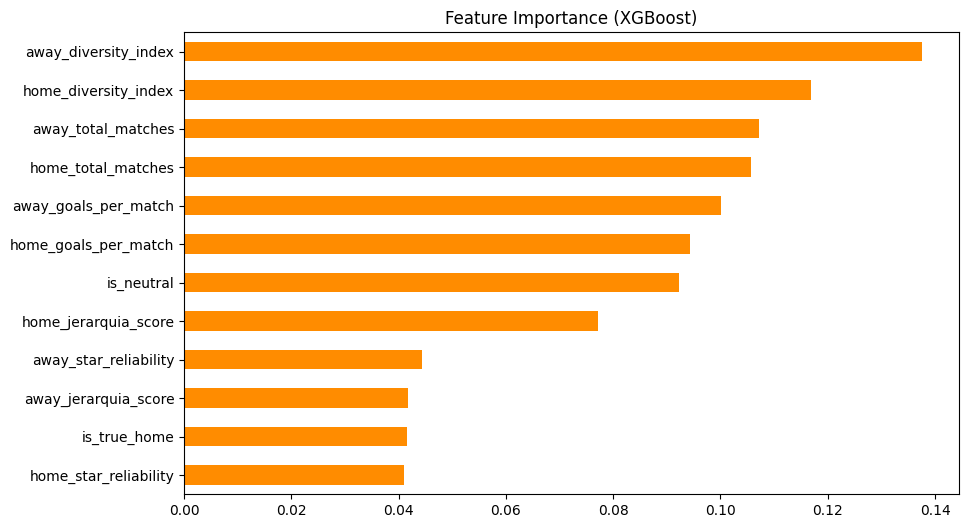

In [13]:
# --- 4. Feature Importance ---
plt.figure(figsize=(10, 6))
importances = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=True)
importances.plot(kind='barh', color='darkorange')
plt.title('Feature Importance (XGBoost)')
plt.show()

In [14]:
# --- 5. Final Evaluation on 2025 Test Set ---
final_preds = xgb.predict(X_test)
print("\n--- Final Test Report (2025 Data) ---")
print(classification_report(y_test_map, final_preds, target_names=['Away Win', 'Draw', 'Home Win']))


--- Final Test Report (2025 Data) ---
              precision    recall  f1-score   support

    Away Win       0.62      0.60      0.61       277
        Draw       0.30      0.03      0.06       202
    Home Win       0.62      0.88      0.73       451

    accuracy                           0.61       930
   macro avg       0.51      0.50      0.47       930
weighted avg       0.55      0.61      0.55       930



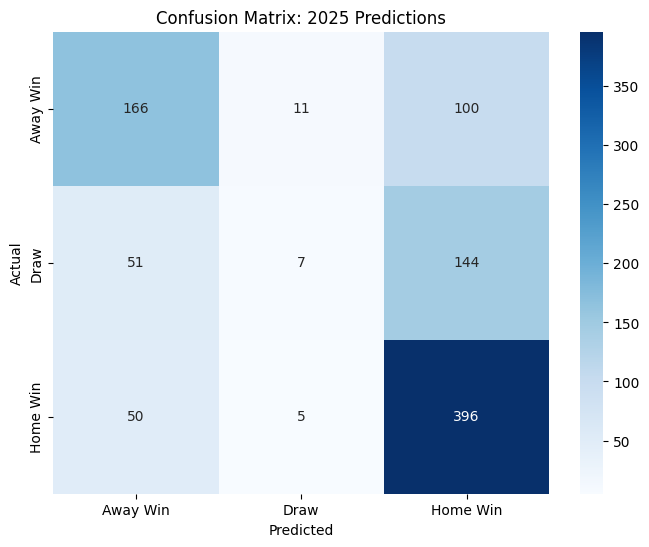

In [15]:
# --- 6. Confusion Matrix Analysis ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_map, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: 2025 Predictions')
plt.show()

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_curves(model, X_test, y_test, title):
    """
    Plots calibration curves for each class (Home Win, Draw, Away Win).
    y_test should be the mapped version (0, 1, 2).
    """
    # Get predicted probabilities for each class
    probs = model.predict_proba(X_test)
    
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    
    classes = ['Away Win', 'Draw', 'Home Win']
    colors = ['red', 'gray', 'blue']
    
    for i in range(len(classes)):
        # Calculate calibration curve for this specific class
        # (Actual == i) vs (Predicted Probability of i)
        prob_true, prob_pred = calibration_curve((y_test == i).astype(int), probs[:, i], n_bins=10)
        
        plt.plot(prob_pred, prob_true, marker='o', label=classes[i], color=colors[i])

    plt.title(f'Probability Calibration Curve: {title}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives (Actual)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the calibration check on your XGBoost model
# Note: Ensure y_test_map is used (values 0, 1, 2)
plot_calibration_curves(xgb, X_test, y_test_map, "XGBoost (2025 Test Set)")